In [2]:
import spikeinterface as si
import matplotlib.pyplot as plt
%matplotlib inline
import spikeinterface.extractors as se
import spikeinterface.preprocessing as spre
import spikeinterface.sorters as ss
import spikeinterface.widgets as sw
import spikeinterface.qualitymetrics as sqm
import json
import numpy as np
import pandas as pd
import seaborn as sns

/home/ubuntu/.conda/envs/spike_sorting_jct/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
global_job_kwargs = dict(n_jobs = 4)
si.set_global_job_kwargs(**global_job_kwargs)

In [4]:
def spike_inf_formation(filepath):
    sorting_curated_phy = se.read_phy(filepath + "/phy_folder_for_kilosort/")
    spike_inf = np.column_stack((np.array(range(0, len(np.load(filepath + "/phy_folder_for_kilosort/spike_clusters.npy").astype(str)))).astype(str),
                                   np.load(filepath + "/phy_folder_for_kilosort/spike_clusters.npy"),
                                   np.load(filepath + "/kilosort4/sorter_output/spike_positions.npy"),
                                   np.load(filepath + "/phy_folder_for_kilosort/spike_templates.npy"),
                                   np.load(filepath + "/phy_folder_for_kilosort/spike_times.npy"),
                                   np.load(filepath + "/phy_folder_for_kilosort/amplitudes.npy")))
    spike_inf = pd.DataFrame(spike_inf)
    spike_inf.columns = ['name', 'cluster', 'position_1', 'position_2', 'template','time', 'amplitude']

    cluster_group = pd.read_csv(filepath + "phy_folder_for_kilosort/cluster_group.tsv", sep = "\t")
    cluster_group = cluster_group[cluster_group['group'] == "good"]

    spike_inf['cluster'] = spike_inf['cluster'].astype('int64')
    spike_inf = spike_inf[spike_inf['cluster'].isin(cluster_group['cluster_id'].values)]    

    sorting_curated_phy = se.read_phy(filepath + "/phy_folder_for_kilosort/", exclude_cluster_groups=['noise'])

    df_1 = pd.DataFrame(list(sorting_curated_phy.count_num_spikes_per_unit().items()), columns=["cluster", 'value'])
    df_1['value'] = df_1['value'].astype(int)
    df_1 = df_1.sort_values(by='value', ascending=False)

    df_2 = pd.DataFrame(np.unique(spike_inf['cluster'], return_counts=True)).T
    df_2.columns = ['cluster', 'value']
    df_2['value'] = df_2['value'].astype(int)
    df_2 = df_2.sort_values(by = 'value', ascending=False)

    spike_inf['cluster'] = spike_inf['cluster'].map(dict(zip(df_2['cluster'], df_1['cluster'])))

    return sorting_curated_phy, spike_inf

In [41]:
sorting_curated_phy_022522, spike_inf_022522 = spike_inf_formation("/media/ubuntu/sda/data/mouse6/output/filtered/mouse6_022522_natural_image_001/")


/tmp/ipykernel_68073/2751270209.py:4: DeprecationWarning: `plot_probe_group` is deprecated and will be removed in 2.23. Use plot_probegroup instead
  plot_probe_group(probe_30channel)


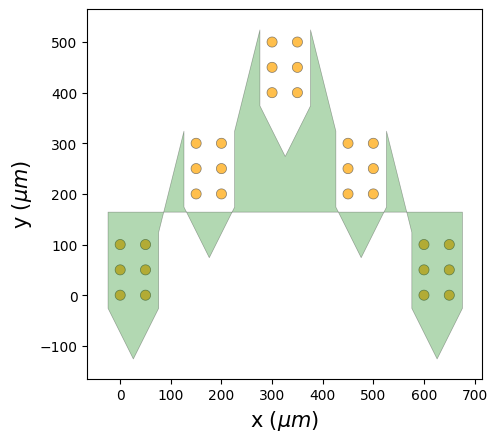

In [7]:
import probeinterface as pi
from probeinterface.plotting import plot_probe_group
probe_30channel = pi.read_probeinterface("/media/ubuntu/sda/data/probe.json")
plot_probe_group(probe_30channel)

In [6]:
file_path = "/media/ubuntu/sda/data/mouse6/ns4/natural_image/mouse6_022522_natural_image_001.ns4"
recording_raw = se.read_blackrock(file_path=file_path).remove_channels(['31', '32'])
recording_raw = recording_raw.set_probegroup(probe_30channel)
recording_raw = spre.bandpass_filter(recording_raw, freq_min=300, freq_max=6000)
recording_raw = spre.common_reference(recording_raw, reference="global", operator="median")

ValueError: Digital filter critical frequencies must be 0 < Wn < fs/2 (fs=10000.0 -> fs/2=5000.0)

In [10]:
def get_channel_id(data):
    x_embedding = data['position_1']
    y_embedding = data['position_2']
    if y_embedding <= 25:
        if x_embedding <= 25:
            return '2'
        elif 25 < x_embedding <= 75:
            return '12'
        elif 75 < x_embedding < 625:
            return '11'
        else:
            return '1'
    elif 25 < y_embedding <= 75:
        if x_embedding <= 25:
            return '4'
        elif 25 < x_embedding <= 75:
            return '10'
        elif 75 < x_embedding < 625:
            return '9'
        else:
            return '3'
    elif 75 < y_embedding <= 125:
        if x_embedding <= 25:
            return '6'
        elif 25 < x_embedding <= 75:
            return '8'
        elif 75 < x_embedding < 625:
            return '7'
        else:
            return '5'
    elif 125 < y_embedding <= 225:
        if 125 < x_embedding <= 175:
            return '14'
        elif 175 < x_embedding <= 225:
            return '24'
        elif 225 < x_embedding < 475:
            return '23'
        else:
            return '13'
    elif 225 < y_embedding <= 275:
        if 125 < x_embedding <= 175:
            return '16'
        elif 175 < x_embedding <= 225:
            return '22'
        elif 225 < x_embedding < 475:
            return '21'
        else:
            return '15'
    elif 275 < y_embedding <= 325:
        if 125 < x_embedding <= 175:
            return '18'
        elif 175 < x_embedding <= 225:
            return '20'
        elif 225 < x_embedding < 475:
            return '19'
        else:
            return '17'
    elif 325 < y_embedding <= 425:
        if 275 < x_embedding <= 325:
            return '26'
        else:
            return '25'
    elif 425 < y_embedding <= 475:
        if 275 < x_embedding <= 325:
            return '28'
        else:
            return '27'
    else:
        if 275 < x_embedding <= 325:
            return '30'
        else:
            return '29'

In [43]:
spike_inf_022522['time'] = spike_inf_022522['time'].astype('int64')
spike_inf_022522['position_1'] = spike_inf_022522['position_1'].astype(float)
spike_inf_022522['position_2'] = spike_inf_022522['position_2'].astype(float)

spike_inf_022522['channel_id'] = spike_inf_022522.apply(get_channel_id, axis=1)

In [12]:
def get_segmentation(start_time, end_time, spike_inf, recording):
    spike_range = spike_inf[spike_inf['time'] > int(start_time * 10000)]
    spike_range = spike_range[spike_range['time'] <= int(end_time * 10000)]
    spike_range = spike_range.loc[:, ('time', 'channel_id')]

    def expand_row(row):
        time_offset = np.arange(-20, 21)
        expand_times = row['time'] + time_offset
        expand_ids = [row['channel_id']] * len(time_offset)
        expanded_df = pd.DataFrame({
            'time': expand_times,
            'channel_id': expand_ids
        })
        return expanded_df

    expanded_spike_range = spike_range.apply(expand_row, axis=1)

    spike_range = pd.concat(expanded_spike_range.tolist())

    traces_dataframe = recording.get_traces(start_frame= start_time * 10000, 
                                            end_frame = end_time * 10000)
    traces_dataframe = pd.DataFrame(traces_dataframe, index=range(int(start_time*10000), int(end_time*10000)))
    traces_dataframe.index = traces_dataframe.index.astype(str)
    traces_dataframe.columns = recording_raw.get_channel_ids().astype(str)

    valid_pairs = set(zip(spike_range['time'].astype(str), spike_range['channel_id'].astype(str)))

    times = traces_dataframe.index.values
    channel_ids = traces_dataframe.columns.values
    
    mask = np.zeros(traces_dataframe.shape, dtype=bool)

    for i, time in enumerate(times):
        for j, channel_id in enumerate(channel_ids):
            if (time, channel_id) in valid_pairs:
                print 
                mask[i, j] = True

    traces_dataframe.values[~mask] = 0
    return traces_dataframe

In [14]:
import os
trigger_time_dict = {}

for filename in os.listdir("/media/ubuntu/sda/data/mouse6/output/get_trigger/trigger_time"):
    if filename.endswith('.csv'):
        file_path = os.path.join("/media/ubuntu/sda/data/mouse6/output/get_trigger/trigger_time/", filename)
        df = pd.read_csv(file_path)
        
        key = filename[:6]
        
        trigger_time_dict[key] = df

In [45]:
for i in range(0, len(trigger_time_dict['022522'])):
    temp = get_segmentation(start_time=(trigger_time_dict['022522'].iloc[i, 1] + 2500)/10000,
                            end_time=(trigger_time_dict['022522'].iloc[i, 2] - 2500)/10000,
                            spike_inf=spike_inf_022522,
                            recording=recording_raw)
    temp.to_csv(f"/media/ubuntu/sda/data/mouse6/output/Segmentation/test/mouse6_022522_{trigger_time_dict['022522'].iloc[i, 3]}_{trigger_time_dict['022522'].iloc[i, 4]}.tsv", sep = '\t', index=False)

In [435]:
a = get_segmentation(start_time= 300, end_time= 301,
                     spike_inf= spike_inf_022323, recording=recording_raw)

In [ ]:
def get_cluster_position(spike_inf):
    cluster_group = np.unique(spike_inf['cluster'])

    cluster_position = pd.DataFrame(columns=['position_1', 'position_2', 'number'])

    for i in cluster_group:
        temp = spike_inf[spike_inf['cluster'] == i]
        temp['position_1'] = temp['position_1'].astype(float)
        temp['position_2'] = temp['position_2'].astype(float)
        cluster_position.loc[i] = [np.mean(temp['position_1']), np.mean(temp['position_2']),
                                len(temp)]
    cluster_position['channel_id'] = cluster_position.apply(get_channel_id, axis=1)
    return cluster_position

In [200]:
def plot_cluster_group(cluster_position):
    plt.figure(figsize=(5,5))

    sns.scatterplot(x = cluster_position['position_1'],
                    y = cluster_position['position_2'],
                    hue=cluster_position.index.astype(str))
    plt.show()

In [432]:
def spike_waveform(spike_inf, file_path):
    templates = np.load(file=file_path)
    templates = np.mean(templates, axis=2, keepdims=False)
    templates = pd.DataFrame(templates)
    templates = pd.DataFrame({
        'row_index': templates.index,
        'row_value': templates.values.tolist()}
    )
    templates['row_index'] = templates['row_index'].astype(str)
    templates = templates.set_index('row_index')['row_value'].to_dict()

    spike_inf['template'] = spike_inf['template'].astype(str)
    spike_inf['waveform'] = spike_inf['template'].map(templates)
    return spike_inf

def get_waveform_segemantation(spike_inf, start_time, end_time):
    spike_inf['time'] = spike_inf['time'].astype(int)
    spike_range = spike_inf[spike_inf['time'] > int(start_time * 10000)]
    spike_range = spike_range[spike_range['time'] <= int(end_time * 10000)]

    spike_range['start'] = (spike_range['time'] - 15 - start_time*10000).astype(int)-1
    spike_range['end'] = (spike_range['time'] + 14 - start_time*10000).astype(int) - 1

    spike_dataframe = pd.DataFrame(np.zeros((len(np.unique(spike_inf['cluster'])), 10000)),
                               index= np.unique(spike_inf['cluster']))
    
    spike_dataframe.columns = range(int(start_time * 10000), int(end_time * 10000))
    spike_dataframe.columns = spike_dataframe.columns.astype(int)

    spike_dataframe.index = spike_dataframe.index.astype(str)
    for index, row in spike_range.iterrows():
        cluster = str(row['cluster'])  
        time = row['time'] 
        waveform = row['waveform']
        start_col = row['start']
        end_col = row['end']

        spike_dataframe.iloc[spike_dataframe.index.get_loc(cluster), start_col:end_col+1] = waveform[:end_col-start_col + 1]
    
    return spike_dataframe

In [403]:
a_1 = get_waveform_segemantation(spike_inf= spike_inf_022323,
                 start_time= 13.3,
                 end_time=14.3)

a_2 = get_waveform_segemantation(spike_inf= spike_inf_022323,
                 start_time= 18.455,
                 end_time=19.455)

In [433]:
spike_inf_022323 = spike_waveform(spike_inf=spike_inf_022323, file_path="/media/zhao/data/mouse16/mouse16_022323_grating_001/output/phy_folder_for_kilosort/templates.npy")

In [413]:
b = spike_inf_022323[['cluster', 'waveform']]
b['waveform'] = b['waveform'].apply(tuple)
b = b.drop_duplicates()

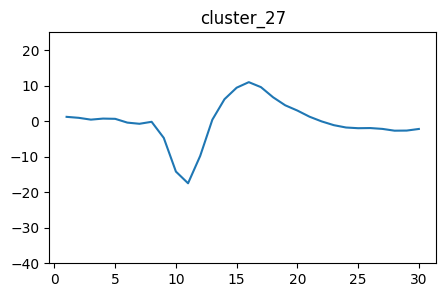

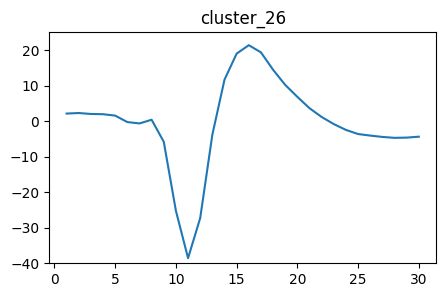

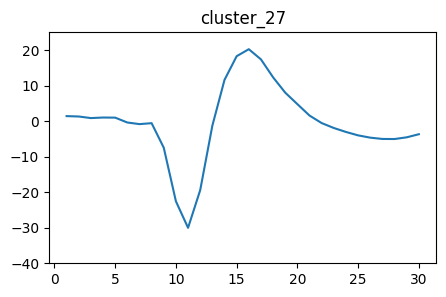

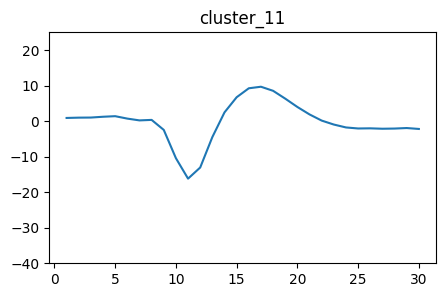

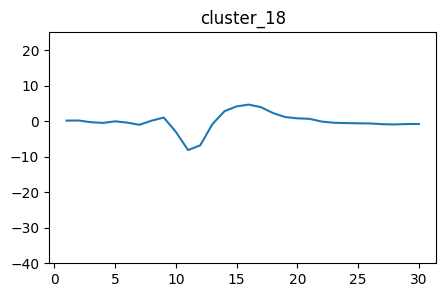

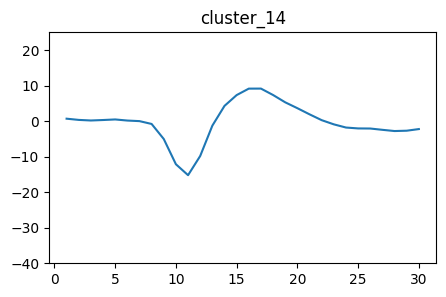

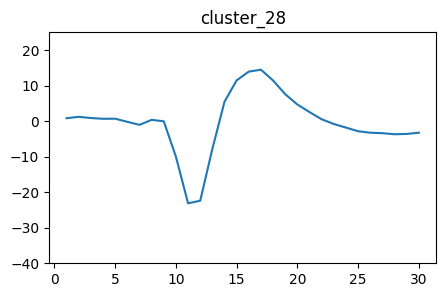

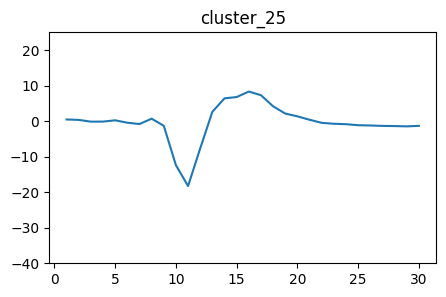

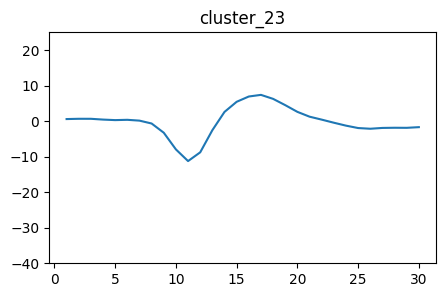

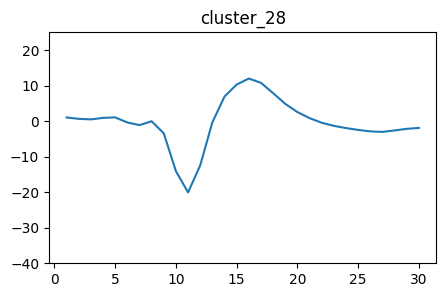

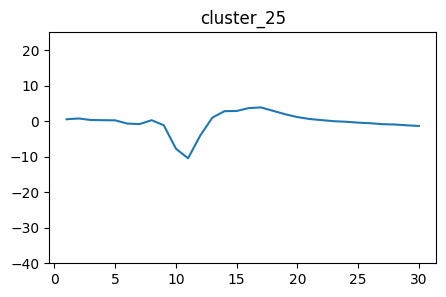

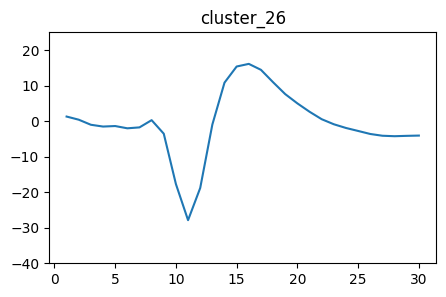

In [427]:
for i in range(0,len(b)):
    temp = b.iloc[i, 1]
    plt.figure(figsize=(5,3))
    sns.lineplot(x = range(1, 31),
                 y = temp)
    plt.ylim(-40, 25)
    plt.title('cluster_' + str(b.iloc[i, 0]))
    plt.show()